In [3]:
from math import *
import matplotlib
import matplotlib.pyplot as plt
import numpy
import scipy.stats
import scipy.integrate

First, let us define the Gauss-Legendre integration method and run a few simple tests.

In [4]:
def GaussLegendreIntegration(func, lower, upper, degree):
    a = .5 * (upper - lower)
    b = .5 * (upper + lower)
    points_and_weights = numpy.polynomial.legendre.leggauss(degree)
    
    result = 0.
    for point, weight in zip(points_and_weights[0], points_and_weights[1]):
        result += func(b + a * point) * weight
        
    return result*a

In [5]:
deg = 7
print(GaussLegendreIntegration(lambda x : 1. / (1 + x**2), 0, 1, deg) - pi / 4.)
print(GaussLegendreIntegration(lambda x : x, 0, 1, deg) - .5)
print(GaussLegendreIntegration(numpy.exp, 0, 1, deg) - (exp(1) - 1.))

6.659891527149853e-10
0.0
4.440892098500626e-16


Next, we will define the Chebyshev interpolation method and use it to recover an unknown function from values on a few pre specified points.

In [6]:
def ChebyshevInterpolationCoefficients(values):
    size = len(values)
    n = size - 1
    multiplier = 2. / n
    coefficients = [0.] * size
    for i in range(size):
        factor = 1.
        if i is 0 or i is n:
            factor = .5
            
        for j in range(size):
            coefficients[j] += multiplier * factor * values[i] * cos(pi * i * j / n)
            
    return coefficients

In [7]:
ChebyshevInterpolationCoefficients([1,2,3,4,6])

[6.25, -1.9571067811865472, 0.24999999999999956, -0.5428932188134523, 0.25]

In [8]:
def ChebyshevInterpolation(values, z):
    coefficients = ChebyshevInterpolationCoefficients(values)
    size = len(coefficients)
    n = size - 1
    
    result = 0.
    for i in range(size):
        factor = 1.
        if i is 0 or i is n:
            factor = .5
            
        result += factor * coefficients[i] * cos(i * acos(z))
        
    return result

In [9]:
ChebyshevInterpolation([1,2,3,4,6],-1)

5.999999999999998

In [10]:
def TestChebyshev(test_func, lower, upper, degree):
    z = [0.] * degree
    values = [0.] * degree
    for i in range(degree):
        z[i] = cos(pi * i / (degree-1))
        values[i] = test_func(lower + (upper - lower) * .5 * (1. + z[i]))
      
    t = numpy.arange(lower, upper, 0.01)
    s1 = [test_func(x) for x in t]
    s2 = [ChebyshevInterpolation(values, 
                                 2. * (x - lower) / (upper - lower) - 1.) for x in t]
    
    fig, ax = plt.subplots()
    ax.plot(t, s1)
    ax.plot(t, s2)
    plt.show()
      
    for i in range(degree):
        diff = abs(values[i] - ChebyshevInterpolation(values,z[i]))
        print(diff)

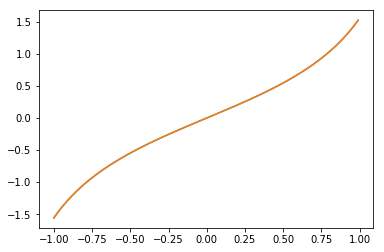

2.220446049250313e-16
2.220446049250313e-16
1.1102230246251565e-16
1.6653345369377348e-16
1.0257883504761298e-16
2.7755575615628914e-16
1.1102230246251565e-16
4.440892098500626e-16
6.661338147750939e-16


In [11]:
test_func = lambda x : tan(x)
TestChebyshev(test_func, -1., 1., 9)

Now, define the ITM probabilities and construct the iteration functions.

In [12]:
def d(boundary, initial, final, vol, pm):
    var = vol * sqrt(final - initial)
    diff = boundary(initial) - boundary(final)
    arg = diff / var + .5 * pm * var
    
    return arg

In [13]:
def d_terminal(boundary, initial, maturity, moneyness, vol, pm):
    var = vol * sqrt(maturity - initial)
    diff = boundary(initial) - moneyness
    arg = diff / var + .5 * pm * var
    
    return arg

In [22]:
def numerator(boundary, 
              moneyness, 
              initial, 
              maturity, 
              vol, 
              discount_curve, 
              discount_curve_deriv, 
              callPut,
              degree):
    result = scipy.stats.norm.cdf(-callPut * d_terminal(boundary,
                                                        initial, 
                                                        maturity, 
                                                        moneyness, 
                                                        vol, 
                                                        -1))
    
    integrand = lambda x: scipy.stats.norm.cdf(-callPut * d(boundary, initial, x, vol, -1)) \
                                           * discount_curve_deriv(x)
    result -= GaussLegendreIntegration(integrand,
                                       initial,
                                       maturity,
                                       degree) / discount_curve(maturity)
                    
    return result                              

In [23]:
def denominator(boundary, 
                moneyness, 
                initial, 
                maturity, 
                vol, 
                discounted_forward, 
                discounted_forward_deriv, 
                callPut,
                degree):
    result = scipy.stats.norm.cdf(-callPut * d_terminal(boundary,
                                                        initial, 
                                                        maturity, 
                                                        moneyness, 
                                                        vol, 
                                                        1))
    
    integrand = lambda x: scipy.stats.norm.cdf(-callPut * d(boundary, initial, x, vol, 1)) \
                                          * discounted_forward_deriv(x)
    result -= GaussLegendreIntegration(integrand,
                                       initial,
                                       maturity,
                                       degree) / discounted_forward(maturity)
                    
    return result                              

From an initial flat exercise boundary, run just one iteration to check the code.

In [47]:
S = 45
K = 45
T = 1.
vol = .2

r = .05
q = .0

call_put = -1
degree = 11

# These two curves are not necessarily exponential.
# Any form will be fine, which is the flexibility of this formulation
discount_curve = lambda x: exp(-r * x)
funding_curve = lambda x: exp(-(r-q) * x)

forward_curve = lambda x: S / funding_curve(x)
discounted_forward_curve = lambda x: discount_curve(x) * forward_curve(x)

discount_curve_deriv = lambda x: -r * discount_curve(x)
discounted_forward_curve_deriv = lambda x: -q * discounted_forward_curve(x)

moneyness = log(K/forward_curve(T))
boundary = lambda x: moneyness

print(numerator(boundary, 
                moneyness, 
                t, 
                T, 
                vol, 
                discount_curve, 
                discount_curve_deriv, 
                call_put, 
                degree))
print(denominator(boundary, 
                  moneyness, 
                  t, 
                  T, 
                  vol, 
                  discounted_forward_curve, 
                  discounted_forward_curve_deriv, 
                  call_put, 
                  degree))

TypeError: only size-1 arrays can be converted to Python scalars

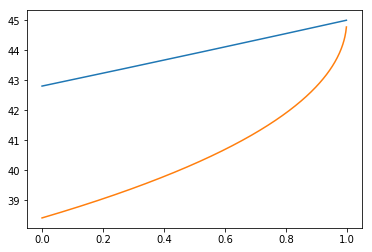

In [48]:
boundary_iter = lambda x: moneyness                \
                        + log(numerator(boundary, 
                                        moneyness, 
                                        x, 
                                        T, 
                                        vol, 
                                        discount_curve, 
                                        discount_curve_deriv, 
                                        call_put,
                                        degree)    \
                             / denominator(boundary, 
                                           moneyness, 
                                           x, 
                                           T, 
                                           vol, 
                                           discounted_forward_curve, 
                                           discounted_forward_curve_deriv, 
                                           call_put,
                                           degree))

t = numpy.arange(0, T, 0.001)
s1 = [forward_curve(x) * exp(boundary(x)) for x in t]
s2 = [forward_curve(x) * exp(boundary_iter(x)) for x in t]

fig, ax = plt.subplots()
ax.plot(t, s1)
ax.plot(t, s2)
plt.show()

In the above single iteration example, we have calculated the early exercise boundary values on a lot of points and then interpolate to form the updated boundary. We will speed up the process by

In [49]:
def SampleValues(boundary,
                 maturity,
                 number_interpolation_points):
    x = [cos(i*pi/(number_interpolation_points)) for i in range(number_interpolation_points+1)]
    return x, [boundary(.5*maturity*(1+y)) for y in x]

In [50]:
points, values = SampleValues(boundary, T, 13)
points, [values[0]] + [boundary_iter(.5*T*(1+x)) for x in points[1:]]

([1.0,
  0.970941817426052,
  0.8854560256532099,
  0.7485107481711011,
  0.5680647467311559,
  0.35460488704253557,
  0.120536680255323,
  -0.12053668025532288,
  -0.35460488704253545,
  -0.5680647467311557,
  -0.7485107481711012,
  -0.8854560256532096,
  -0.970941817426052,
  -1.0],
 [-0.049999999999999996,
  -0.0685061935468004,
  -0.08530809329735287,
  -0.10024189236164338,
  -0.11322997231280058,
  -0.12427468489412397,
  -0.13344764894958455,
  -0.1408752593468858,
  -0.1467213849332883,
  -0.15116845576762555,
  -0.15439828033305858,
  -0.15657397368394285,
  -0.15782431074771078,
  -0.15823164954622673])

In [51]:
def EarlyExerciseBoundaryIteration(values,
                                   points,
                                   moneyness,
                                   maturity,
                                   vol,
                                   call_put,
                                   discount_curve,
                                   discount_curve_deriv,
                                   discounted_forward_curve,
                                   discounted_forward_curve_deriv,
                                   number_integration_points):
    boundary_interp = lambda x: ChebyshevInterpolation(values, 2.*x/maturity-1.)
    boundary_iter = lambda x: moneyness                \
                            + log(numerator(boundary_interp, 
                                            moneyness, 
                                            x, 
                                            maturity, 
                                            vol, 
                                            discount_curve, 
                                            discount_curve_deriv, 
                                            call_put,
                                            number_integration_points))    \
                             - log(denominator(boundary_interp, 
                                               moneyness, 
                                               x, 
                                               maturity, 
                                               vol, 
                                               discounted_forward_curve, 
                                               discounted_forward_curve_deriv, 
                                               call_put,
                                               number_integration_points))
    
    return [values[0]] + [boundary_iter(.5*maturity*(1+x)) for x in points[1:]]

In [52]:
def CalculateEarlyExerciseBoundaryByIteration(initial_boundary,
                                              moneyness,
                                              maturity,
                                              vol,
                                              call_put,
                                              discount_curve,
                                              discount_curve_deriv,
                                              discounted_forward_curve,
                                              discounted_forward_curve_deriv,
                                              number_integration_points,
                                              number_interpolation_points,
                                              number_iterations):
    points, values = SampleValues(initial_boundary, maturity, number_interpolation_points)
    new_values = [values]
    for i in range(number_iterations):
        new_values.append(EarlyExerciseBoundaryIteration(new_values[i],
                                                         points,
                                                         moneyness,
                                                         maturity,
                                                         vol,
                                                         call_put,
                                                         discount_curve,
                                                         discount_curve_deriv,
                                                         discounted_forward_curve,
                                                         discounted_forward_curve_deriv,
                                                         number_integration_points))
        
    return new_values

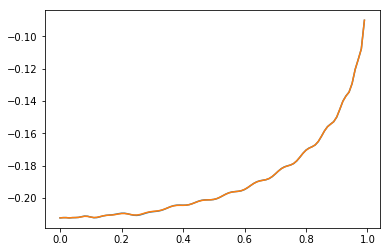

In [53]:
number_integration_points = 13
number_interpolation_points = 35
number_iterations = 10
iteration_values = CalculateEarlyExerciseBoundaryByIteration(boundary,
                                                             moneyness,
                                                             T,
                                                             vol,
                                                             call_put,
                                                             discount_curve,
                                                             discount_curve_deriv,
                                                             discounted_forward_curve,
                                                             discounted_forward_curve_deriv,
                                                             number_integration_points,
                                                             number_interpolation_points,
                                                             number_iterations)
    
t = numpy.arange(0, T, 0.01)
fig, ax = plt.subplots()
for iter_values in iteration_values[-1:-3:-1]:
    boundary_interp = lambda x: ChebyshevInterpolation(iter_values, 2.*x/T-1.)
#     s = [discounted_forward(x) / discount(x) * exp(boundary_interp(x)) for x in t]
    s = [boundary_interp(x) for x in t]
    ax.plot(t, s)

plt.show()

In [54]:
[fabs(x - y)/max(fabs(x), fabs(y)) for x, y in zip(iteration_values[-1], iteration_values[-2])]

[0.0,
 0.0001790460544295784,
 0.00012409466438629947,
 0.0005954079852143442,
 0.0008679134659269166,
 0.000988499945430959,
 0.0008333657560752847,
 0.0008070348993611905,
 0.0006572784352249462,
 0.0006286596116676206,
 0.0005152290002577192,
 0.00048545358120080976,
 0.0004006425171326397,
 0.0003872454913855014,
 0.00031751040676759597,
 0.0003118040368117691,
 0.00025417954028496807,
 0.0002272057634246568,
 0.00032065493337427774,
 9.380217560651931e-05,
 0.0005351866053796504,
 0.0001957730231348035,
 0.0007507735807008401,
 0.0012297133606098732,
 0.0001055997663478303,
 0.0007433981075369374,
 0.0002042891552277484,
 0.0005912779893417297,
 0.00020780582294490017,
 0.00036429984573848473,
 9.356967841257099e-05,
 0.00010654856859929816,
 0.0002270234749113124,
 6.660458168743628e-05,
 3.352082070367215e-05,
 5.232731803454049e-05]

In [55]:
def EuropeanOptionPrice(spot,
                        strike,
                        initial,
                        maturity,
                        vol,
                        discount_curve,
                        forward_curve,
                        call_put):
    forward_funding = forward_curve(maturity) / forward_curve(initial)
    forward_discounting = discount_curve(maturity) / discount_curve(initial)
    forward = spot * forward_funding

    moneyness = log(forward/strike)
    var = vol * sqrt(maturity - initial)
    dOne = moneyness/var + .5*var
    dTwo = dOne - var

    return call_put * forward_discounting * (forward * scipy.stats.norm.cdf(call_put * dOne)
                                            -strike  * scipy.stats.norm.cdf(call_put * dTwo))

In [57]:
EuropeanOptionPrice(S, K, 0., T, vol, discount_curve, forward_curve, -1)

2.5080867100156397

In [60]:
def AmericanOptionPriceFromEarlyExerciseBoundary(spot,
                                                 strike,
                                                 initial,
                                                 maturity,
                                                 vol,
                                                 call_put,
                                                 discount_curve,
                                                 discount_curve_deriv,
                                                 discounted_forward_curve,
                                                 discounted_forward_curve_deriv,
                                                 boundary,
                                                 number_valuation_integration_points):
    forward_curve = lambda x: discounted_forward_curve(x) / discount_curve(x)
    result = EuropeanOptionPrice(spot, strike, initial, maturity, vol, discount_curve, forward_curve, call_put)
    
    temp = log(spot / forward_curve(initial))
    moneyness = lambda x: temp - boundary(x)
    var = lambda x: vol * sqrt(x - initial)
    dOne = lambda x: moneyness(x)/var(x) + .5*var(x)
    dTwo = lambda x: dOne(x) - var(x)
    integrand = lambda x: call_put * ( discount_curve_deriv(x) * strike
                                     * scipy.stats.norm.cdf(call_put * dTwo(x))
                                     - discounted_forward_curve_deriv(x) * spot / forward_curve(initial)
                                     * scipy.stats.norm.cdf(call_put * dOne(x)) )
    result += GaussLegendreIntegration(integrand, initial, maturity, number_valuation_integration_points) / discount_curve(initial)
    
    return result

In [68]:
number_valuation_integration_points = 27
boundary_interp = lambda x: ChebyshevInterpolation(iteration_values[-1], 2.*x/T-1.)
AmericanOptionPriceFromEarlyExerciseBoundary(S, K, 0., T, vol, -1, discount_curve, discount_curve_deriv,
                                             discounted_forward_curve, discounted_forward_curve_deriv, boundary_interp, 
                                             number_valuation_integration_points)

2.740709177268308